### Modele DNN

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
import joblib

In [ ]:
df_pretraited = pd.read_csv("data/dataPreprocessed.csv", low_memory=False)
df_pretraited.head()

,normality,sourceID_freq,accessed_addr_freq,src_dest_same_addr,src_dest_same_type,src_dest_same_loc,value_movement,value_tempin,value_lightOn,value_heatingcontrol,...,value_movement_present,value_lightOn_present,value_heatingcontrol_present,acc_node_event_present,hour_sin,hour_cos,delta_time,events_per_min,is_night,is_work_hours
0,0,0.040505,0.000003,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,0,-0.258819,0.965926,-0.072967,0.209502,0,0
1,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,0.220811,0.274155,0,0
2,0,0.040505,0.018952,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.028332,0.274155,0,0
3,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.054648,0.274155,0,0
4,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.072456,0.274155,0,0


#### Split des donnees

In [5]:
# X = tes features, y = ta target (0=normal, 1=anomalie)
X = df_pretraited.copy()
X = X.drop(columns=['normality'])
y = df_pretraited['normality']


# Split train+val et test (80%-20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split train et validation (80%-20% du train+val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

print("Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

Train: 229088 Validation: 57273 Test: 71591


In [6]:
print("Train (%):\n", y_train.value_counts(normalize=True) * 100)
print("\nValidation (%):\n", y_val.value_counts(normalize=True) * 100)
print("\nTest (%):\n", y_test.value_counts(normalize=True) * 100)

Train (%):
 normality
0    97.201512
1     2.798488
Name: proportion, dtype: float64

Validation (%):
 normality
0    97.201124
1     2.798876
Name: proportion, dtype: float64

Test (%):
 normality
0    97.202162
1     2.797838
Name: proportion, dtype: float64


In [37]:
#Verification que tout les types des colone n'ayont pas des object
print(X_train.dtypes)
print("="*51)
print(X_test.dtypes)

sourceID_freq                               float64
accessed_addr_freq                          float64
src_dest_same_addr                            int64
src_dest_same_type                            int32
src_dest_same_loc                             int64
value_movement                              float64
value_tempin                                float64
value_lightOn                               float64
value_heatingcontrol                        float64
value_charge                                float64
src_device_info_freq                        float64
dest_device_info_freq                       float64
sourceType_risk                               int64
sourceType_is_lightControler                  int64
sourceType_is_sensorService                   int64
sourceType_is_batteryService                  int64
destinationServiceType_risk                   int64
destinationServiceType_is_sensorService       int64
destinationServiceType_is_batteryService      int64
destinationS

In [21]:
# On a un seul colone src_dest_same_type (bool)
bool_cols = X_train.select_dtypes(include=['bool']).columns

X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols]   = X_val[bool_cols].astype(int)

In [38]:
bool_cols = X_test.select_dtypes(include=['bool']).columns

X_test[bool_cols] = X_test[bool_cols].astype(int)

In [39]:
#Verification
print(X_train.dtypes)
print("="*51)
print(X_test.dtypes)

sourceID_freq                               float64
accessed_addr_freq                          float64
src_dest_same_addr                            int64
src_dest_same_type                            int32
src_dest_same_loc                             int64
value_movement                              float64
value_tempin                                float64
value_lightOn                               float64
value_heatingcontrol                        float64
value_charge                                float64
src_device_info_freq                        float64
dest_device_info_freq                       float64
sourceType_risk                               int64
sourceType_is_lightControler                  int64
sourceType_is_sensorService                   int64
sourceType_is_batteryService                  int64
destinationServiceType_risk                   int64
destinationServiceType_is_sensorService       int64
destinationServiceType_is_batteryService      int64
destinationS

In [41]:
X_train_np = X_train.values
X_val_np   = X_val.values
X_test_np  = X_test.values

y_train_np = y_train.values
y_val_np   = y_val.values
y_test_np  = y_test.values

In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_np
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weight_dict


{0: 0.5143952900389354, 1: 17.866791452191546}

In [25]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

c:\Users\hp\Desktop\mainSimulationAccessTraces.csv (1)\iotvenv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)


In [27]:
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [28]:
history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=50,
    batch_size=1024,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.9894 - Precision: 0.4455 - Recall: 0.9276 - accuracy: 0.9657 - loss: 0.1444 - val_AUC: 0.9997 - val_Precision: 0.8859 - val_Recall: 0.9981 - val_accuracy: 0.9964 - val_loss: 0.0245
Epoch 2/50
 31/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9994 - Precision: 0.8440 - Recall: 0.9914 - accuracy: 0.9944 - loss: 0.0320

c:\Users\hp\Desktop\mainSimulationAccessTraces.csv (1)\iotvenv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9992 - Precision: 0.8633 - Recall: 0.9928 - accuracy: 0.9954 - loss: 0.0299 - val_AUC: 0.9997 - val_Precision: 0.9285 - val_Recall: 0.9963 - val_accuracy: 0.9977 - val_loss: 0.0116
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9997 - Precision: 0.9186 - Recall: 0.9963 - accuracy: 0.9974 - loss: 0.0131 - val_AUC: 0.9998 - val_Precision: 0.9451 - val_Recall: 0.9981 - val_accuracy: 0.9983 - val_loss: 0.0077
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9994 - Precision: 0.9215 - Recall: 0.9978 - accuracy: 0.9976 - loss: 0.0135 - val_AUC: 0.9997 - val_Precision: 0.9703 - val_Recall: 0.9981 - val_accuracy: 0.9991 - val_loss: 0.0098
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9997 - Precision: 0.9511 - Recall: 0.9991 - accuracy: 0.9985 - loss: 0.0082 - val_AUC: 0.9998 - val_Precision: 0.9662 - val_Recall: 1.0000 - val_accuracy: 0.9990 - val_loss: 0.0067
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
joblib.dump(model, "models/dnn_model.pkl")

['dnn_model.pkl']

In [ ]:
model = rf = joblib.load("models/dnn_model.pkl")
results = model.evaluate(X_test_np, y_test_np, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

loss: 0.0022
compile_metrics: 0.9997


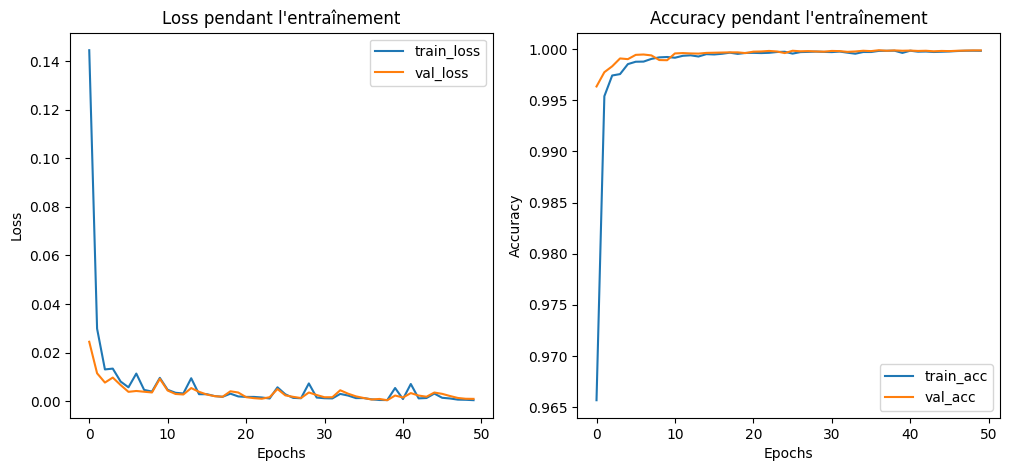

In [30]:
# Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy (ou metrics que tu as choisi)
plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Loss (perte) :
La perte sur l’entraînement (history loss) et sur la validation (history val loss) diminue progressivement au fil des époques, ce qui montre que ton modèle apprend correctement et s’adapte bien aux données.

Accuracy (précision) :
L’accuracy d’entraînement et de validation est très élevée, proche de 1 (ou 100 %).

Training accuracy final : ~0.9998 → presque toutes les prédictions d’entraînement sont correctes.

Validation accuracy final : ~0.9999 → le modèle généralise très bien sur les données de validation.

2238/2238 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step


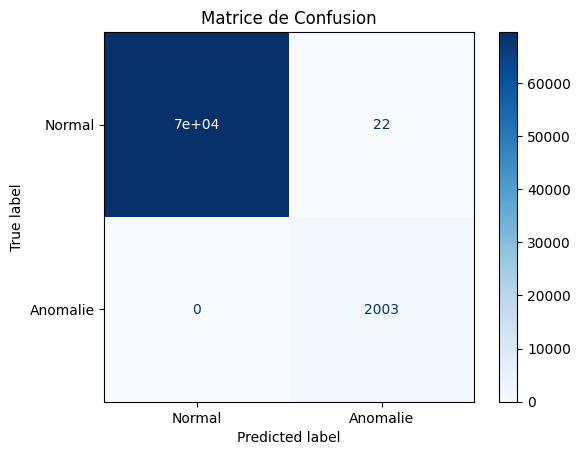

In [47]:
y_pred_prob = model.predict(X_test_np)
y_pred = (model.predict(X_test_np) > 0.5).astype(int)  # seuil 0.5
cm = confusion_matrix(y_test_np, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Anomalie'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

True Positives (TP) = 2003 → anomalies correctement détectées

True Negatives (TN) = 69566 → normales correctement détectées

False Positives (FP) = 22 → normales faussement détectées comme anomalies

False Negatives (FN) = 0 → anomalies manquées (aucune anomalie ratée)

2238/2238 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step
Precision: 0.9891
Recall   : 1.0000
F1-Score : 0.9945
ROC curve AUC =  0.9999868816365036


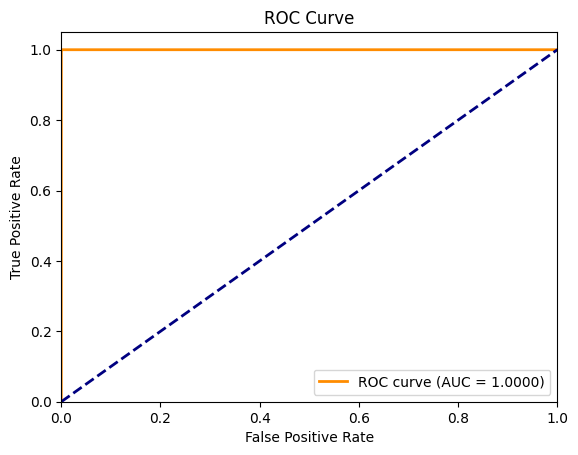

In [49]:
y_score = model.predict(X_test_np)
fpr, tpr, thresholds = roc_curve(y_test_np, y_score)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test_np, y_pred)
recall = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

print("ROC curve AUC = ", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print("History loss: ",history.history['loss'])
print("History val Loss: ", history.history['val_loss'])
print("History accuracy: ", history.history['accuracy'])
print("History val accuracy: ", history.history['val_accuracy'])
print("matrix de confusion: \n",cm)


History loss:  [0.1443939507007599, 0.029900694265961647, 0.013145333155989647, 0.013479350134730339, 0.00816349033266306, 0.005788527894765139, 0.011439448222517967, 0.0047211111523211, 0.004032696597278118, 0.009672403335571289, 0.004758036695420742, 0.003544420702382922, 0.003252096474170685, 0.009522771462798119, 0.0029601077549159527, 0.0029507360886782408, 0.0021768936421722174, 0.0018851786153391004, 0.0031770134810358286, 0.002039380604401231, 0.0018375524086877704, 0.001841207267716527, 0.0016039576148614287, 0.0011959372786805034, 0.005792024079710245, 0.002921723760664463, 0.001449159230105579, 0.0013001718325540423, 0.007386041805148125, 0.0015772130573168397, 0.001300786854699254, 0.0012241293443366885, 0.0030742257367819548, 0.0024056003894656897, 0.0013560943771153688, 0.0013636031653732061, 0.0008429295849055052, 0.0005745731177739799, 0.0005384924588724971, 0.00550319068133831, 0.0009653804590925574, 0.007150641176849604, 0.0012403444852679968, 0.0013886578381061554, 0